In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from pyDOE import lhs

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict

import scipy.io
from sklearn.feature_selection import mutual_info_regression

import time
from tqdm import tqdm

sns.set_style("white")


# Schrödinger equation is a linear partial differential equation that 
# governs the wave function of a quantum-mechanical system.
# It is used to predicts the future behavior of a dynamic system.

c:\Users\omi222\Anaconda3\envs\project_lehigh\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

import numpy as np
# Set Seed
seed = 120
import random
#torch.random.seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

noise = 0

# Domain bounds
lb = torch.tensor([-5.0, 0.0]).float()
ub = torch.tensor([5.0, np.pi/2]).float()

N0 = 50
N_b = 50
N_f = 20000
layers = [2, 100, 2, 4]

data = scipy.io.loadmat("data/NLS.mat")

t = torch.tensor(data["tt"]).flatten()#[:, None]
x = torch.tensor(data["x"]).flatten()#[:, None]

Exact = data["uu"]
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)


X, T = torch.meshgrid(x, t, indexing = 'xy')#.reshape(2, -1) # 1D inputs required

X_star = torch.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact_u.T.flatten()[:, None]
v_star = Exact_v.T.flatten()[:, None]
h_star = Exact_h.T.flatten()[:, None]


# Initial values
idx_x = np.random.choice(x.shape[0], N0, replace = False)
x0 = x[idx_x][:, None]
u0 = Exact_u[idx_x, 0:1]
v0 = Exact_v[idx_x, 0:1]

idx_t = np.random.choice(t.shape[0], N_b, replace = False)
tb = t[idx_t][:, None]

X_f = lb + (ub-lb)*lhs(2, N_f)  # pyDOE lhs used for generating quasi-random multidimensional samples

In [4]:

# noise = 0
# Set Seed
seed = 120
import random
#torch.random.seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# Domain bounds
lb = np.array([-5.0, 0.0])
ub = np.array([5.0, np.pi/2])

N0 = 50
N_b = 50
N_f = 20000
layers = [2, 100, 2, 4]

data = scipy.io.loadmat("data/NLS.mat")

t = data["tt"].flatten()[:, None]
x = data["x"].flatten()[:, None]

Exact = data["uu"]
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)


X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact_u.T.flatten()[:, None]
v_star = Exact_v.T.flatten()[:, None]
h_star = Exact_h.T.flatten()[:, None]


# Initial values
idx_x = np.random.choice(x.shape[0], N0, replace = False)
x0 = x[idx_x, :]
u0 = Exact_u[idx_x, 0:1]
v0 = Exact_v[idx_x, 0:1]

idx_t = np.random.choice(t.shape[0], N_b, replace = False)
tb = t[idx_t, :]

X_f1 = lb + (ub-lb)*lhs(2, N_f)  # pyDOE lhs used for generating quasi-random multidimensional samples

In [5]:

noise = 0

# Domain bounds
lb = torch.tensor([-5.0, 0.0]).float()
ub = torch.tensor([5.0, np.pi/2]).float()

N0 = 50
N_b = 50
N_f = 20000
layers = [2, 100, 2, 4]

data = scipy.io.loadmat("data/NLS.mat")

t = torch.tensor(data["tt"]).flatten().float()#[:, None]
x = torch.tensor(data["x"]).flatten().float()#[:, None]

Exact = torch.tensor(data["uu"])
Exact_u = torch.real(Exact).float()
Exact_v = torch.imag(Exact).float()
Exact_h = torch.sqrt(Exact_u**2 + Exact_v**2)


X, T = torch.meshgrid(x, t, indexing = 'xy')#.reshape(2, -1) # 1D inputs required

X_star = torch.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact_u.T.flatten()[:, None]
v_star = Exact_v.T.flatten()[:, None]
h_star = Exact_h.T.flatten()[:, None]


# Initial values
idx_x = np.random.choice(x.shape[0], N0, replace = False)
x0 = x[idx_x][:, None]
u0 = Exact_u[idx_x, 0:1]
v0 = Exact_v[idx_x, 0:1]

idx_t = np.random.choice(t.shape[0], N_b, replace = False)
tb = t[idx_t][:, None]

X_f = lb + (ub-lb)*lhs(2, N_f)  # pyDOE lhs used for generating quasi-random multidimensional samples



In [6]:
# Create MLP for model training



class PINN(nn.Module):
    def __init__(self, input_size, hidden_size,
                 output_size, n_layers) -> None:
        super(PINN, self).__init__()

        layers = [("input", torch.nn.Linear(input_size, hidden_size))]
        layers.append(("input_activation", torch.nn.Tanh()))

        # For every other layer
        for i in range(n_layers):
            layers = layers + [
                (f"hidden_{i}", torch.nn.Linear(hidden_size, hidden_size)),
                (f"activation{i}", torch.nn.Tanh()),
            ]

        layers.append(("output", torch.nn.Linear(hidden_size, output_size)))

        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        ##print(type(x))
        out = self.layers(x)
        return out


class ModelNetwork():
    def __init__(self, x0, u0, v0, tb, X_f, layers, lb, ub):
        
        ########################################
        # Initialize model Inputs and parameters
        
        X0 = torch.concat((x0, 0*x0), 1)
        X_lb = torch.concat((0*tb + lb[0], tb), 1)
        X_ub = torch.concat((0*tb + ub[0], tb), 1)
        
        # Periodic Boundary Conditions
        self.lb = lb
        self.ub = ub
        
        self.x0 = X0[:, 0:1].requires_grad_()
        self.t0 = X0[:, 1:2].requires_grad_()
        
        self.x_lb = X_lb[:, 0:1].requires_grad_()
        self.t_lb = X_lb[:, 1:2].requires_grad_()
        
        self.x_ub = X_ub[:, 0:1].requires_grad_()
        self.t_ub = X_ub[:, 1:2].requires_grad_()
        
        self.x_f = X_f[:, 0:1].float().requires_grad_()
        self.t_f = X_f[:, 1:2].float().requires_grad_()
        
        self.u0 = u0
        self.v0 = v0
        
        self.pinn = PINN(*layers)
        
        self.optimizer = torch.optim.LBFGS(
            self.pinn.parameters(),
            # lr = 1.0, 
            max_iter = 50000,
            max_eval = 50000,
            history_size = 50,
            tolerance_change=1.0 * np.finfo(float).eps
        )
        self.optimizer_Adam = torch.optim.Adam(self.pinn.parameters())
        self.iter = 0
        
    def net_uv(self, x, t):
        X = torch.concat([x,t], 1)
        X = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        uv = self.pinn(X)
        u = uv[:, 0:1]
        v = uv[:, 1:2]
        
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u)
                                  , retain_graph = True, create_graph = True)[0]
        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(u)
                                  , retain_graph=True, create_graph = True)[0]
        
        return u, v, u_x, v_x
        
    def net_f_uv(self, x, t):
        u, v, u_x, v_x = self.net_uv(x, t)
        
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u)
                                  , retain_graph = True, create_graph = True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x)
                                  , retain_graph = True, create_graph = True)[0]
        
        v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v)
                                  , retain_graph = True, create_graph = True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x)
                                  , retain_graph = True, create_graph = True)[0]
        
        f_u = u_t + 0.5*v_xx + (u**2 + v**2)*v
        f_v = v_t - 0.5*u_xx - (u**2 + v**2)*u
        
        return f_u, f_v
        
    def loss_func(self):
        u0_pred, v0_pred, _, _ = self.net_uv(self.x0, self.t0)
        u_lb_pred, v_lb_pred, u_x_lb_pred, v_x_lb_pred = self.net_uv(self.x_lb, self.t_lb)
        u_ub_pred, v_ub_pred, u_x_ub_pred, v_x_ub_pred= self.net_uv(self.x_ub, self.t_ub) 
        f_u_pred, f_v_pred = self.net_f_uv(self.x_f, self.t_f)       
        
        loss = (torch.mean((self.u0 - u0_pred)**2) +
                torch.mean((self.v0 - v0_pred)**2) + 
                torch.mean((u_lb_pred- u_ub_pred)**2) + 
                torch.mean((v_lb_pred- v_ub_pred)**2) +
                torch.mean((u_x_lb_pred - u_x_ub_pred)**2) + 
                torch.mean((v_x_lb_pred - v_x_ub_pred)**2) + 
                torch.mean((f_u_pred)**2) + torch.mean((f_v_pred)**2)
                )
        self.optimizer.zero_grad()
        loss.backward()
        
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                "Iter: %d, Loss: %.5f" %
                (
                    self.iter,  loss.item()
            ))
            
        
        return loss
    
    def train(self, epochs):
        for epoch in range(epochs):
            self.optimizer_Adam.step(self.loss_func)
            if self.iter >= 7000:
                break
        self.optimizer.step(self.loss_func)

In [7]:
seed = 4
import random
#torch.random.seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

model = ModelNetwork(x0, u0, v0, tb, X_f, layers, lb, ub)
start = time.time()
model.train(5000)
print("Training took: " + str(time.time() - start))

Iter: 100, Loss: 0.10293
Iter: 200, Loss: 0.05554
Iter: 300, Loss: 0.04618
Iter: 400, Loss: 0.04119
Iter: 500, Loss: 0.03680
Iter: 600, Loss: 0.03400
Iter: 700, Loss: 0.03225
Iter: 800, Loss: 0.03049
Iter: 900, Loss: 0.03808
Iter: 1000, Loss: 0.02810
Iter: 1100, Loss: 0.02645
Iter: 1200, Loss: 0.02514
Iter: 1300, Loss: 0.02395
Iter: 1400, Loss: 0.02302
Iter: 1500, Loss: 0.02236
Iter: 1600, Loss: 0.02279
Iter: 1700, Loss: 0.02091
Iter: 1800, Loss: 0.02067
Iter: 1900, Loss: 0.04218
Iter: 2000, Loss: 0.02012
Iter: 2100, Loss: 0.01870
Iter: 2200, Loss: 0.01824
Iter: 2300, Loss: 0.02978
Iter: 2400, Loss: 0.01779
Iter: 2500, Loss: 0.01583
Iter: 2600, Loss: 0.01525
Iter: 2700, Loss: 0.01512
Iter: 2800, Loss: 0.01429
Iter: 2900, Loss: 0.01374
Iter: 3000, Loss: 0.01365
Iter: 3100, Loss: 0.01289
Iter: 3200, Loss: 0.06277
Iter: 3300, Loss: 0.01207
Iter: 3400, Loss: 0.01192
Iter: 3500, Loss: 0.01185
Iter: 3600, Loss: 0.01263
Iter: 3700, Loss: 0.01364
Iter: 3800, Loss: 0.01096
Iter: 3900, Loss: 0.0

KeyboardInterrupt: 

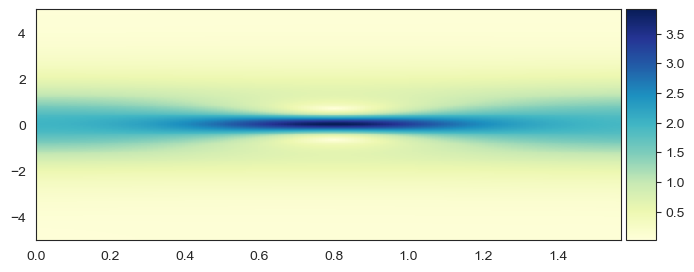

In [8]:
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

X_star  =X_star.requires_grad_()
# u_pred, v_pred, _, _ = model.net_uv(X_star[:, 0:1], X_star[:, 1:2])
# f_u_pred, f_v_pred = model.net_f_uv(X_star[:, 0:1], X_star[:, 1:2])
    
u_pred, v_pred, f_u_pred, f_v_pred = model.net_uv(X_star[:, 0:1], X_star[:, 1:2])
h_pred = np.sqrt(u_pred.detach().numpy()**2 + v_pred.detach().numpy()**2)

H_pred = griddata(X_star.detach().numpy(), h_pred.flatten(), (X, T), method = 'cubic')

fig = plt.figure(figsize = (8, 3))
ax = fig.add_subplot(111)

h = ax.imshow(H_pred.T, interpolation='nearest', cmap='YlGnBu',
                extent=[lb[1], ub[1], lb[0], ub[0]], 
                origin='lower', aspect='auto')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

In [ ]:
u0_pred, v0_pred, _, _ = model.net_uv(X_star[:, 0:1], X_star[:, 1:2])